In [20]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ./scripts/util_func.py

In [21]:
# import data to dataframe

data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/powertrain_dynamics_IPEM/data/data_joint_states.csv") 

data = data.iloc[1:]

print(data)

       Unnamed: 0      ros_time  wheel_meas_index  cmd_left_vel  \
1               1  1.604067e+18               0.0           0.0   
2               2  1.604067e+18               0.0           0.0   
3               3  1.604067e+18               0.0           0.0   
4               4  1.604067e+18               0.0           0.0   
5               5  1.604067e+18               0.0           0.0   
...           ...           ...               ...           ...   
88271       88271  1.604068e+18            3366.0           0.0   
88272       88272  1.604068e+18            3366.0           0.0   
88273       88273  1.604068e+18            3366.0           0.0   
88274       88274  1.604068e+18            3366.0           0.0   
88275       88275  1.604068e+18            3366.0           0.0   

       meas_left_vel  cmd_right_vel  meas_right_vel  left_js_vel  \
1                0.0            0.0         0.00000          0.0   
2                0.0            0.0         0.00000        

In [22]:
# convert dataframe to numpy array

array = data.to_numpy()
array =np.delete(array,[0],axis=0)

time_arr = array[:,1]
time_arr = (time_arr - time_arr[0]) * 10**(-9)
meas_index_arr = array[:,2]

left_vel_cmd_arr = array[:,3]
left_vel_meas_arr = array[:,4]
right_vel_cmd_arr = array[:,5]
right_vel_meas_arr = array[:,6]

left_vel_js_arr = array[:,7]
right_vel_js_arr = array[:,8]

linear_odom_vel_arr = array[:,9]
angular_odom_vel_arr = array[:,10]

left_EKF_vel = np.genfromtxt('data/left_ekf_mod_vel.csv', delimiter=',')
right_EKF_vel = np.genfromtxt('data/right_ekf_mod_vel.csv', delimiter=',')

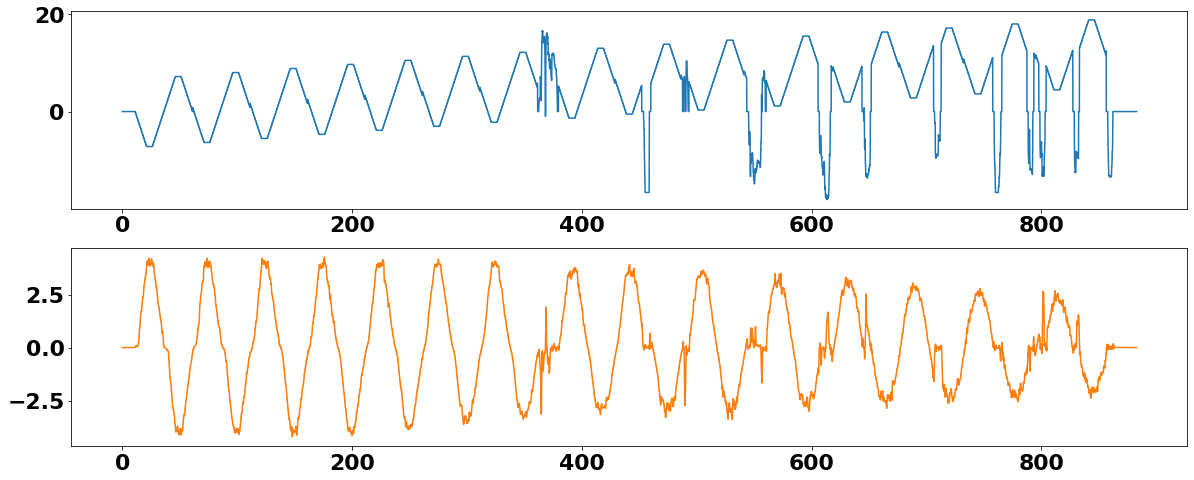

In [23]:
plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr, left_vel_cmd_arr, c='tab:blue', label='tau_c_left')
plt.subplot(212)
plt.plot(time_arr, angular_odom_vel_arr, c='tab:orange', label='tau_c_right')

In [42]:
# Run model on all data

# init tau_c and tau_d values

tau_c = 0.01
tau_d = 0.1

left_model_vel = np.zeros((meas_index_arr.shape[0]))
right_model_vel = np.zeros((meas_index_arr.shape[0]))

for i in range(10, meas_index_arr.shape[0]-1):
    
    dt = (time_arr[i] - time_arr[i-1])
    left_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_model_vel, i, dt)
    right_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, right_vel_cmd_arr, right_model_vel, i, dt)

In [43]:
# compute diff_drive model

r = 0.3 # wheel radius (m)
B = 1.2 # wheel baseline (m)

cmd_linear_odom_arr = np.zeros((meas_index_arr.shape[0]))
cmd_angular_odom_arr = np.zeros((meas_index_arr.shape[0]))

enc_linear_odom_arr = np.zeros((meas_index_arr.shape[0]))
enc_angular_odom_arr = np.zeros((meas_index_arr.shape[0]))

model_linear_odom_arr = np.zeros((meas_index_arr.shape[0]))
model_angular_odom_arr = np.zeros((meas_index_arr.shape[0]))

js_linear_odom_arr = np.zeros((meas_index_arr.shape[0]))
js_angular_odom_arr = np.zeros((meas_index_arr.shape[0]))

ekf_linear_odom_arr = np.zeros((meas_index_arr.shape[0]))
ekf_angular_odom_arr = np.zeros((meas_index_arr.shape[0]))

for i in range(left_vel_cmd_arr.shape[0]):
    cmd_linear_odom_arr[i], cmd_angular_odom_arr[i] = diff_drive(left_vel_cmd_arr[i], right_vel_cmd_arr[i], r, B)
    enc_linear_odom_arr[i], enc_angular_odom_arr[i] = diff_drive(left_vel_meas_arr[i], right_vel_meas_arr[i], r, B)
    model_linear_odom_arr[i], model_angular_odom_arr[i] = diff_drive(left_model_vel[i], right_model_vel[i], r, B)
    js_linear_odom_arr[i], js_angular_odom_arr[i] = diff_drive(left_vel_js_arr[i], right_vel_js_arr[i], r, B)
    ekf_linear_odom_arr[i], ekf_angular_odom_arr[i] = diff_drive(left_EKF_vel[i], right_EKF_vel[i], r, B)
    
    
    

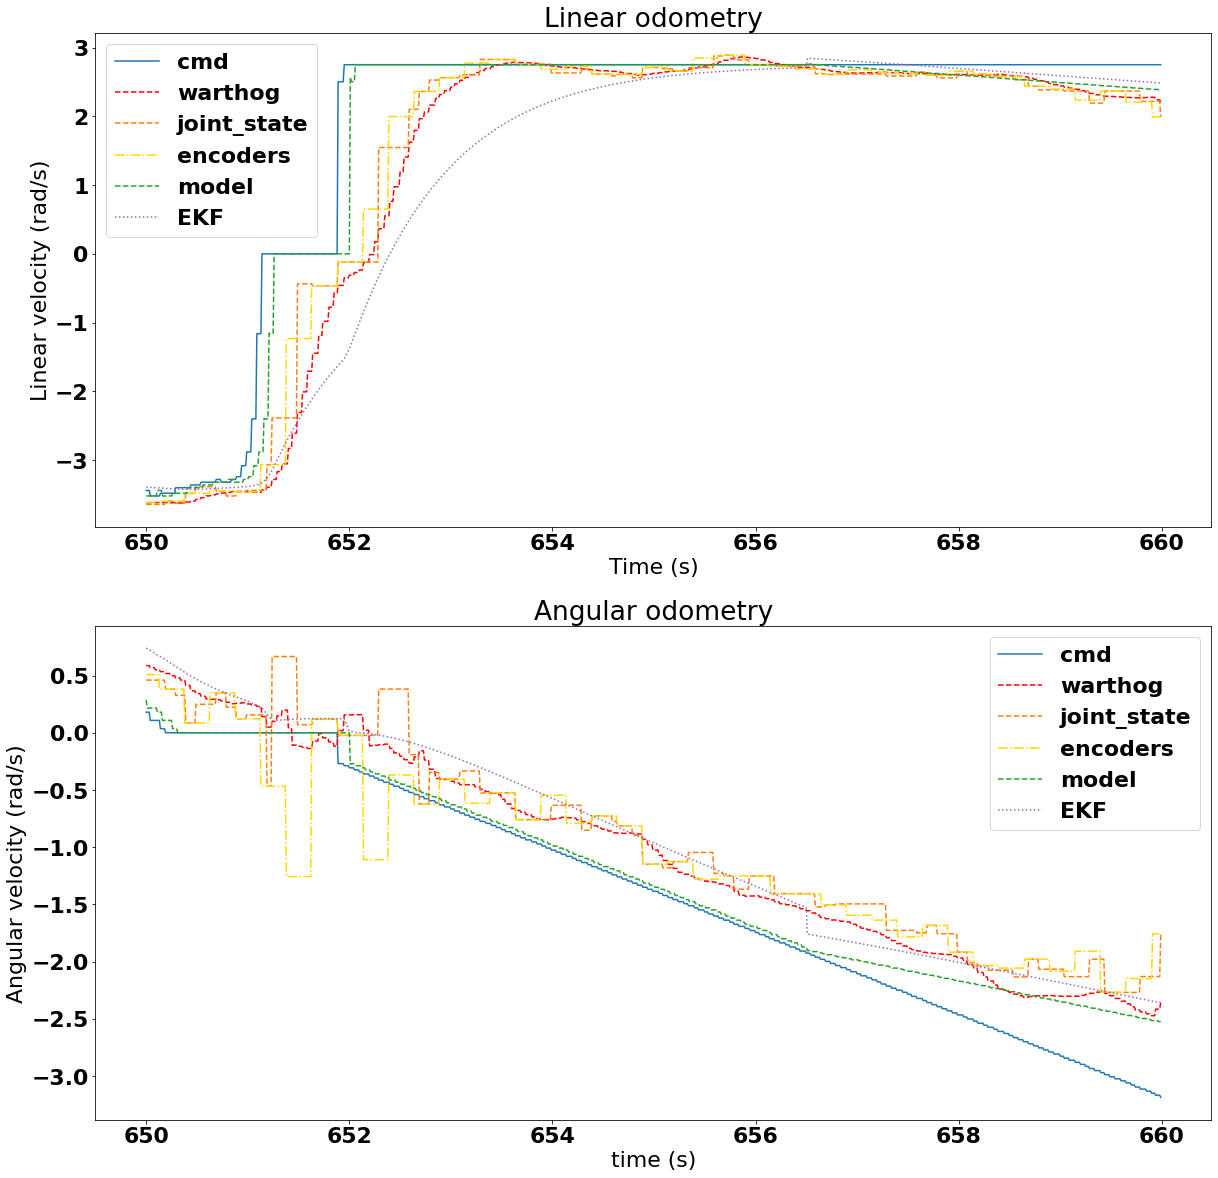

In [44]:
slice_start = 65000
slice_end = 66000

plt.figure(2, figsize=(20,20))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], cmd_linear_odom_arr[slice_start:slice_end], c='tab:blue', label='cmd', linestyle = 'solid')
plt.plot(time_arr[slice_start:slice_end], linear_odom_vel_arr[slice_start:slice_end], c='red', linestyle = 'dashed', label='warthog')
plt.plot(time_arr[slice_start:slice_end], js_linear_odom_arr[slice_start:slice_end], c='tab:orange', label='joint_state', linestyle = 'dashed')
plt.plot(time_arr[slice_start:slice_end], enc_linear_odom_arr[slice_start:slice_end], c='gold', label='encoders', linestyle = 'dashdot')
plt.plot(time_arr[slice_start:slice_end], model_linear_odom_arr[slice_start:slice_end], c='tab:green', label='model', linestyle = 'dashed')
plt.plot(time_arr[slice_start:slice_end], ekf_linear_odom_arr[slice_start:slice_end], c='tab:purple', label='EKF', linestyle = 'dotted')
plt.xlabel('Time (s)')
plt.ylabel('Linear velocity (rad/s)')
plt.title('Linear odometry')
plt.legend()
plt.subplot(212)
plt.plot(time_arr[slice_start:slice_end], cmd_angular_odom_arr[slice_start:slice_end], c='tab:blue', label='cmd', linestyle = 'solid')
plt.plot(time_arr[slice_start:slice_end], angular_odom_vel_arr[slice_start:slice_end], c='red', linestyle = 'dashed', label='warthog')
plt.plot(time_arr[slice_start:slice_end], js_angular_odom_arr[slice_start:slice_end], c='tab:orange', label='joint_state', linestyle = 'dashed')
plt.plot(time_arr[slice_start:slice_end], enc_angular_odom_arr[slice_start:slice_end], c='gold', label='encoders', linestyle = 'dashdot')
plt.plot(time_arr[slice_start:slice_end], model_angular_odom_arr[slice_start:slice_end], c='tab:green', label='model', linestyle = 'dashed')
plt.plot(time_arr[slice_start:slice_end], ekf_angular_odom_arr[slice_start:slice_end], c='tab:purple', label='EKF', linestyle = 'dotted')
plt.xlabel('time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular odometry')
plt.legend()